# Medida de Regularidade temporal em função das tentativas 

## Funções e imports

In [9]:
import pandas as pd
from spikeHelper.dataOrganization import loadBestParams, getX,XyTfromEpoch,trialToXyT, normRows
from spikeHelper.metrics import performanceFromConfusion
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
from spikeHelper.loadSpike import Rat
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def removeTrialsWithMuchActivity(unitTimeTrialCubic, devs = 2,trials=[]):
    trialActivity = unitTimeTrialCubic.sum(axis=1).mean(axis=0)
    base = np.median(trialActivity)
    threshold = base + devs*trialActivity.std()
    print('Removing %d trials' %(trialActivity > threshold).sum())
    
    if len(trials)>0:
        return unitTimeTrialCubic[:,:,trialActivity < threshold], trials[trialActivity < threshold]
    
    return unitTimeTrialCubic[:,:,trialActivity < threshold]

def removeNeuronsThatDoNotFire(unitTimeTrialCubic,threshold = 10):
    trialActivity = unitTimeTrialCubic.mean(axis=2).sum(axis=1)
    print('Removing %d neurons' %(trialActivity < threshold).sum())
    
    return unitTimeTrialCubic[trialActivity > threshold,:,:]

In [11]:
from scipy.stats import pearsonr
def performanceFromConfusion(cubicConfusion,kind='corr',weights = 'linear',returnP = False):

    '''Accepts 'corr', for pearsonr, and 'kappa' for cohen's linear weighted kappa score'''
    allYtrue = np.array([])
    allYpred = np.array([])
    cubicConfusion = cubicConfusion[:,cubicConfusion.sum(axis=2).sum(axis=1)>0,:]
    for trial in range(cubicConfusion.shape[2]):
        real,predicted = np.nonzero(cubicConfusion[:,:,trial])
        allYtrue = np.hstack((allYtrue,real))
        allYpred = np.hstack((allYpred,predicted))

    if kind == 'corr':
        if returnP:
            return pearsonr(allYtrue,allYpred)
        return pearsonr(allYtrue,allYpred)[0]
    elif kind == 'kappa':
        return cohen_kappa_score(allYtrue,allYpred,weights = weights)
    elif kind == 'r2':
        return r2_score(allYtrue,allYpred)
    elif kind == 'mse':
        return mean_squared_error(allYtrue,allYpred)

In [12]:
def temporalWindow(X,y,ytrial, windowTrials,clf,returnCubic=True):
    n_classes = len(np.unique(y))

    if not isinstance(clf,SVC):
        clf.fit(X,y)

    times = np.unique(y)
    trials = np.unique(ytrial)

    confusionPerTrial = np.full((n_classes,n_classes,trials.shape[0]),np.nan)
    for i,testTrial in enumerate(trials[:-windowTrials]):
        clfi = clone(clf)
        lastIdxEqualTest = np.nonzero(trials>testTrial)[0][0]
        toUse = trials[lastIdxEqualTest:lastIdxEqualTest+windowTrials]
        traintrials = np.array([t in toUse for t in ytrial]).reshape(-1)
        clfi.fit(X[traintrials,:],y[traintrials])
        confusionPerTrial[:,:,i] = confusion_matrix(y[ytrial==testTrial], clfi.predict(X[ytrial==testTrial]))

    return confusionPerTrial

In [13]:
def shuffleAllTrialBins(neuronTimeTrial,shuffling):
    return neuronTimeTrial.take( np.random.permutation(shuffling) ,axis=1)

## Calculate correlation in windows

In [14]:
srat = Rat(8)

In [30]:
srat.selecTrials({'minDuration':1200, 'ntrials':3})
srat.selecTimes(tmin= 200, tmax=1000,shuffle=True)
srat.describe()
srat.y.reshape(3,8)

Bins have been shuffled
Label: Rat 8
Bin size: 100
Sigma: 100

Using 3 trials, according to following restrictions:
minDuration: 1200
ntrials: 3
The 8 bins have been shuffled


array([[3, 8, 4, 7, 5, 6, 2, 9],
       [3, 8, 4, 7, 5, 6, 2, 9],
       [3, 8, 4, 7, 5, 6, 2, 9]])

In [8]:
results = pd.DataFrame(columns = ['value','trials'])
for windowTrials in [6,15,40]:#np.logspace(np.log10(6),np.log10(300),30)[:5].astype(int):
    ntrials = -1
    for ratN in [8]:
        
        
        data = Rat(ratN,100,50)
        data.selecTrials({'minDuration': 1300,'maxDuration':5000,'ntrials':100+windowTrials})
        for shuf in range(100):
            data.selecTimes(tmin = 200, tmax = 1000,shuffle=True)
            parameters = loadBestParams(ratN)
            clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
            aux = temporalWindow(data.X, data.y, data.trial ,windowTrials, clf,returnCubic=True)
            aux1 = np.array([performanceFromConfusion(aux[:,:,i:i+50]) for i in range(50)])
            aux = performanceFromConfusion(aux[:,:,:100])
            results= pd.concat((results,pd.DataFrame({'TotalCorr':[aux],
                                                      'Walkin':[aux1],
                                                      'trials':[np.unique(data.trial)],
                                                      'window':windowTrials,
               
                                                      
                                                      'shuffle':shuffle},
                                                      index=[ratN],
                                                      )),axis=0)

KeyboardInterrupt: 

In [ ]:
W = results.groupby('window').apply(lambda x: np.vstack(x.Walkin.values))

In [ ]:
W[6].std()

In [50]:
W[6].mean()

0.0064789035188801474

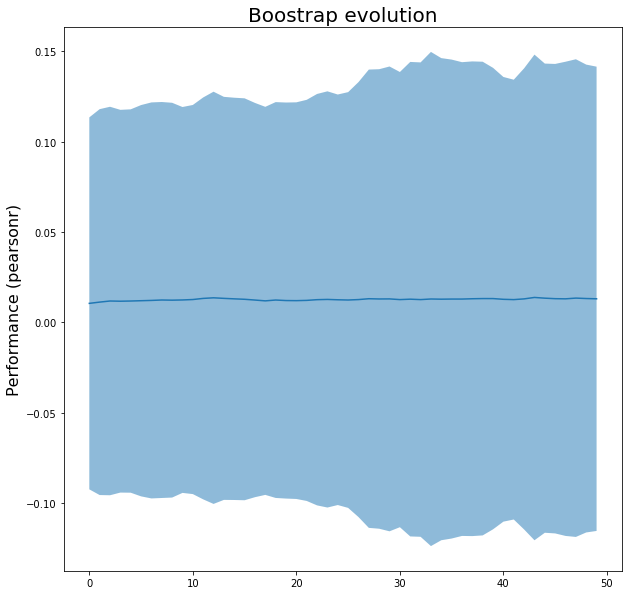

In [47]:
plt.figure(figsize=(10,10))
plt.plot(W[40].mean(axis=0))
plt.fill_between(np.arange(50),W[40].mean(axis=0)-3*W[40].std(axis=0),W[40].mean(axis=0)+3*W[40].std(axis=0),alpha=.5)

plt.title('Boostrap evolution',fontsize=20)
plt.ylabel('Performance (pearsonr)',fontsize=16)

In [32]:
results['score'] = results.value.apply(lambda x: np.array([performanceFromConfusion(x[:,:,i:i+50]) for i in range(50)] ))

In [54]:
mean = np.vstack(results['score'].values).mean(axis=0)
dev = np.vstack(results['score'].values).std(axis=0)

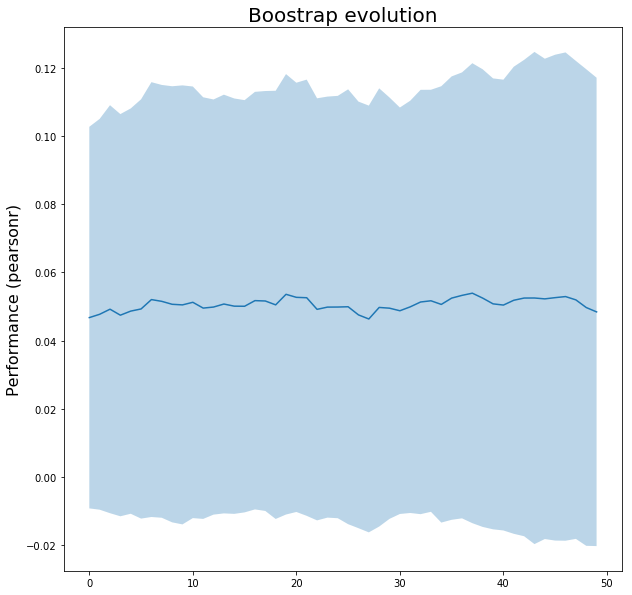

In [63]:
plt.figure(figsize=(10,10))
plt.plot(mean)
plt.fill_between(np.arange(len(mean)),mean-dev,mean+dev,alpha=.3)
plt.title('Boostrap evolution',fontsize=20)
plt.ylabel('Performance (pearsonr)',fontsize=16)

In [65]:
res = np.vstack(results['score'].values)

(array([  83.,  250.,  115.,   95.,   39.,    7.,   41.,   57.,   41.,   22.]),
 array([-0.03367337, -0.00866503,  0.01634331,  0.04135165,  0.06635999,
         0.09136834,  0.11637668,  0.14138502,  0.16639336,  0.1914017 ,
         0.21641004]),
 <a list of 10 Patch objects>)

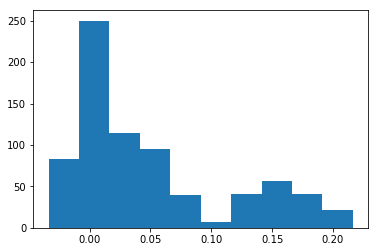

In [69]:
plt.hist(res.ravel())

## Bootstrap small windows

In [25]:
#pickle.dump(results,open('bootstrapWindow6_10.pickle','wb'))
print('Media %.2f'%results.value.apply(lambda x: performanceFromConfusion(x[:,:,:100])).mean())
print('Desvio %.2f'%results.value.apply(lambda x: performanceFromConfusion(x[:,:,:100])).std())

Media 0.03
Desvio 0.05


In [71]:
small = pickle.load(open('bootstrapWindow6_10.pickle','rb'))

In [76]:
small['score'] = small.value.apply(lambda x: performanceFromConfusion(x[:,:,:100]) )

In [80]:
small.drop('value',axis=1)

,shuffle,trials,window,score
7,0.0,"[10, 13, 15, 18, 19, 21, 34, 36, 38, 42, 43, 5...",6.0,0.003690
7,1.0,"[10, 13, 15, 18, 19, 21, 34, 36, 38, 42, 43, 5...",6.0,-0.010613
7,2.0,"[10, 13, 15, 18, 19, 21, 34, 36, 38, 42, 43, 5...",6.0,-0.008437
7,3.0,"[10, 13, 15, 18, 19, 21, 34, 36, 38, 42, 43, 5...",6.0,-0.007113
7,4.0,"[10, 13, 15, 18, 19, 21, 34, 36, 38, 42, 43, 5...",6.0,0.001612
8,0.0,"[0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 25, 26...",6.0,0.007693
8,1.0,"[0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 25, 26...",6.0,-0.026892
8,2.0,"[0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 25, 26...",6.0,0.155154
8,3.0,"[0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 25, 26...",6.0,0.043584
8,4.0,"[0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 25, 26...",6.0,0.039712


In [82]:
small.groupby(['window','shuffle']).agg(np.mean)

score
window shuffle          
6.0    0.0      0.013769
       1.0     -0.000854
       2.0      0.055471
       3.0      0.030124
       4.0      0.019674
10.0   0.0      0.035686
       1.0      0.109614
       2.0      0.021617
       3.0      0.008729
       4.0      0.043852

(array([  4.,  11.,   9.,   7.,   3.,   2.,   1.,   2.,   0.,   1.]),
 array([-0.04118515, -0.01662658,  0.00793199,  0.03249057,  0.05704914,
         0.08160772,  0.10616629,  0.13072486,  0.15528344,  0.17984201,
         0.20440059]),
 <a list of 10 Patch objects>)

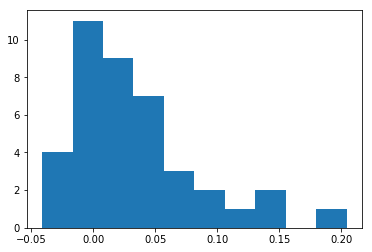

In [78]:
plt.hist(small.score)

In [16]:
results.score

7    NaN
7    NaN
7    NaN
7    NaN
7    NaN
8    NaN
8    NaN
8    NaN
8    NaN
8    NaN
9    NaN
9    NaN
9    NaN
9    NaN
9    NaN
10   NaN
10   NaN
10   NaN
10   NaN
10   NaN
7    NaN
7    NaN
7    NaN
7    NaN
7    NaN
8    NaN
8    NaN
8    NaN
8    NaN
8    NaN
9    NaN
9    NaN
9    NaN
9    NaN
9    NaN
10   NaN
10   NaN
10   NaN
10   NaN
10   NaN
Name: score, dtype: float64

In [10]:
results.reset_index().groupby(['index','window']).apply(lambda x: x.score.apply(np.mean))

index  window    
7      6.0     0    -0.006452
               1    -0.018349
               2     0.003881
               3    -0.011854
               4     0.009450
       10.0    20   -0.038275
               21   -0.019383
               22   -0.017514
               23   -0.016896
               24    0.004472
8      6.0     5     0.024428
               6    -0.012320
               7     0.152222
               8     0.040478
               9     0.046124
       10.0    25    0.138276
               26    0.121484
               27    0.023620
               28    0.027002
               29    0.075684
9      6.0     10    0.019263
               11    0.000134
               12    0.039355
               13   -0.023179
               14    0.015616
       10.0    30   -0.007501
               31    0.212900
               32    0.046507
               33    0.013929
               34    0.040477
10     6.0     15    0.042085
               16    0.017165
               17    0

In [11]:
results.reset_index().groupby(['index','window']).apply(lambda x: x.score.apply(np.std))

index  window    
7      6.0     0     0.013104
               1     0.015454
               2     0.012241
               3     0.006668
               4     0.023169
       10.0    20    0.015634
               21    0.013324
               22    0.021435
               23    0.014815
               24    0.009927
8      6.0     5     0.014254
               6     0.017722
               7     0.030234
               8     0.010329
               9     0.013512
       10.0    25    0.009358
               26    0.016794
               27    0.015027
               28    0.015639
               29    0.006388
9      6.0     10    0.008006
               11    0.010977
               12    0.012114
               13    0.012249
               14    0.006553
       10.0    30    0.015080
               31    0.040700
               32    0.011021
               33    0.007158
               34    0.015780
10     6.0     15    0.017690
               16    0.015405
               17    0

In [297]:
results['score'].apply(lambda x: np.mean(x)) + results['score'].apply(lambda x: np.std(x.score)*2)

7    -0.024307
8     0.228428
9     0.078018
10    0.143623
7     0.016740
8     0.051521
9     0.103103
10    0.037074
7     0.063867
8     0.186443
9     0.183605
10    0.041260
7     0.022761
8     0.141800
9     0.121377
10    0.085978
7     0.030276
8     0.044605
9     0.114010
10    0.190613
Name: score, dtype: float64

In [305]:
res = results['score'].apply(lambda x: np.mean(x)) + results['score'].apply(lambda x: np.std(x))

In [306]:
res[8]

8    0.211757
8    0.031266
8    0.173953
8    0.122933
8    0.030929
Name: score, dtype: float64

In [17]:
import seaborn as sns

In [310]:
results.groupby('window').apply(lambda x: x.score.apply(lambda x: np.mean(x) ).mean() )

window
6.0     0.038590
7.0     0.086381
8.0     0.041863
10.0    0.056462
dtype: float64

In [313]:
results.groupby('window').apply(lambda x: x.score.apply(lambda x: np.mean(x) ).std()*2 )

window
6.0     0.156313
7.0     0.155661
8.0     0.088735
10.0    0.110408
dtype: float64

In [ ]:
results['walkin'] = results.value.apply(lambda x: [performanceFromConfusion(x[:,:,i:i+10]) for i in range(90)])

In [166]:
a=np.arange(10)

In [ ]:
a.take()

---

In [64]:
pickle.dump(results,open('evolutionLogWindowsAllRats.pickle','wb'))

In [5]:
results = pickle.load(open('evolutionLogWindowsAllRats.pickle','rb'))

(array([ 0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ]),
 <a list of 7 Text yticklabel objects>)

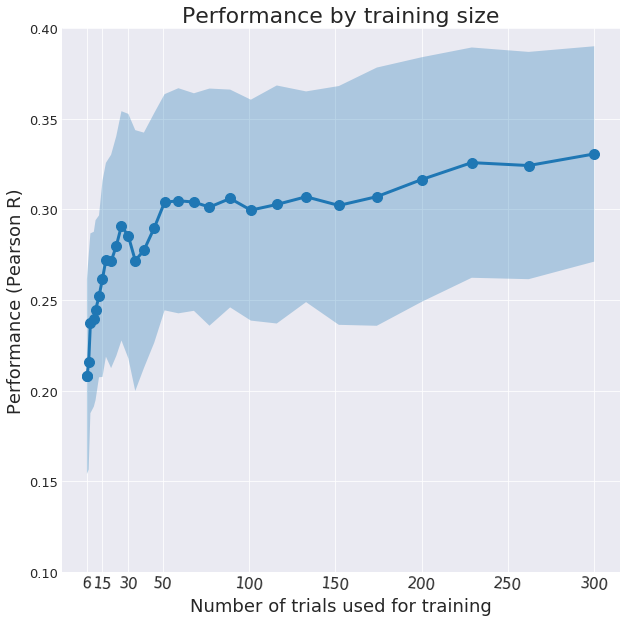

In [118]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
meanP = np.c_[r7,r8,r9,r10].mean(axis=1)
stdP = np.c_[r7,r8,r9,r10].std(axis=1)
plt.plot(np.logspace(np.log10(6),np.log10(300),30).astype(int),meanP,'-o',linewidth=3,markersize=10)
plt.fill_between(np.logspace(np.log10(6),np.log10(300),30).astype(int),meanP-stdP/2,meanP+stdP/2,alpha=.3)
plt.xticks([6,15,30,50,100,150,200,250,300],fontsize=15,rotation=-5)
plt.ylim([0.1,.4])
plt.xlabel('Number of trials used for training',fontsize=18)
plt.title('Performance by training size',fontsize=22)
plt.ylabel('Performance (Pearson R)',fontsize=18)
plt.yticks(fontsize=13)

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
fig = plt.figure(figsize=(13,8))
cpoints = {7: [157, 265, 394], 8 :[314, 486, 565], 9 : [176, 713], 10 : [32, 119, 357]}

smoothSize = 50
bestPoin = {7: 500, 8:500, 9:300, 10:1000}
for ratN in [8]:
    for t,window in enumerate([12]):
        #plt.subplot(4,1,(ratN-6))
        smoothed = [performanceFromConfusion(results['value'][ratN][:,:,i:i+smoothSize],kind='corr',returnP=True) 
                    for i in range(results['value'][ratN].shape[2]-smoothSize*2)]
        r = [s[0] for s in smoothed]
        p = [s[1] for s in smoothed]
        plt.plot(results['trials'][ratN][:results['value'][ratN].shape[2]-smoothSize*2],r)
        p=np.array(p)
        t = results['trials'][ratN][:90]#results['value'][ratN].shape[2]-smoothSize*2]
        plt.plot([0,402],[0,0],linewidth=5,color='b')
        plt.plot([429,t.max()],[0,0],linewidth=5,color='b',label='p < .05')
        plt.legend(fontsize=21)
        #for pt in bestPoin[ratN]:
        #plt.axvline(bestPoin[ratN],linestyle='--',color='r',linewidth=3)
    #plt.xticks([])
    #plt.title('Rat %s'%(ratN))
    plt.ylabel('Classifier performance',fontsize=24);
    plt.xlabel('Trial number',fontsize=24)

IndexError: tuple index out of range

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
fig = plt.figure(figsize=(13,8))
cpoints = {7: [157, 265, 394], 8 :[314, 486, 565], 9 : [176, 713], 10 : [32, 119, 357]}

smoothSize = 50
bestPoin = {7: 500, 8:500, 9:300, 10:1000}
for ratN in [8]:
    for t,window in enumerate([12]):
        #plt.subplot(4,1,(ratN-6))
        smoothed = [performanceFromConfusion(results['value'][ratN][:,:,i:i+smoothSize],kind='corr',returnP=True) 
                    for i in range(results['value'][ratN].shape[2]-smoothSize*2)]
        r = [s[0] for s in smoothed]; p = np.array([s[1] for s in smoothed])
        
        plt.plot(results['trials'][ratN][:results['value'][ratN].shape[2]-smoothSize*2],r)
        t = results['trials'][ratN][results['value'][ratN].shape[2]-smoothSize*2]
        
        plt.plot([0,402],[0,0],linewidth=5,color='b')
        plt.plot([429,t.max()],[0,0],linewidth=5,color='b',label='p < .05')
        
        plt.legend(fontsize=21)
        #for pt in bestPoin[ratN]:
        #plt.axvline(bestPoin[ratN],linestyle='--',color='r',linewidth=3)
    #plt.xticks([])
    #plt.title('Rat %s'%(ratN))
    plt.ylabel('Classifier performance',fontsize=24);
    plt.xlabel('Trial number',fontsize=24)

NameError: name 'results' is not defined

In [84]:
results['trials'][ratN].values[0]

array([  0,  11,  12,  13,  14,  15,  16,  19,  20,  23,  25,  26,  27,
        28,  29,  30,  32,  33,  37,  38,  41,  43,  47,  49,  53,  54,
        55,  56,  57,  58,  59,  63,  65,  66,  68,  69,  70,  76,  78,
        79,  80,  81,  87,  89,  90,  92,  94,  95,  96,  97, 100, 103,
       104, 105, 106, 109, 110, 113, 115, 118, 121, 130, 131, 133, 135,
       136, 137, 138, 141, 142, 143, 144, 145, 147, 148, 151, 153, 155,
       156, 158, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172,
       173, 177, 179, 180, 183, 184, 186, 187, 188, 189, 191, 193, 199,
       201, 204])

In [ ]:
p=
data = Rat(ratN,100,50)
data.selecTrials({'minDuration': 1300,'maxDuration':5000})
data.selecTimes(tmin = 200, tmax = 1000)

parameters = loadBestParams(ratN)
clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
aux=temporalGeneralization(data.X,data.y,data.trial,clf,returnCubic=True)
p.append(performanceFromConfusion(aux))

In [3]:
import seaborn as sns
from spikeHelper.loadSpike import Rat

In [16]:
r8 = Rat(8)

In [17]:
r8.selecTrials({'minDuration':1500,'maxDuration':3000})
r8.selecTimes(tmin=200,tmax=1000)
r8.describe()

Label: Rat 8
Bin size: 100
Sigma: 100

Using 372 trials, according to following restrictions:
minDuration: 1500
maxDuration: 3000

Using 8 time bins:
From 200 to 300ms
From 300 to 400ms
From 400 to 500ms
.
.
.
From 800 to 900ms
From 900 to 1000ms


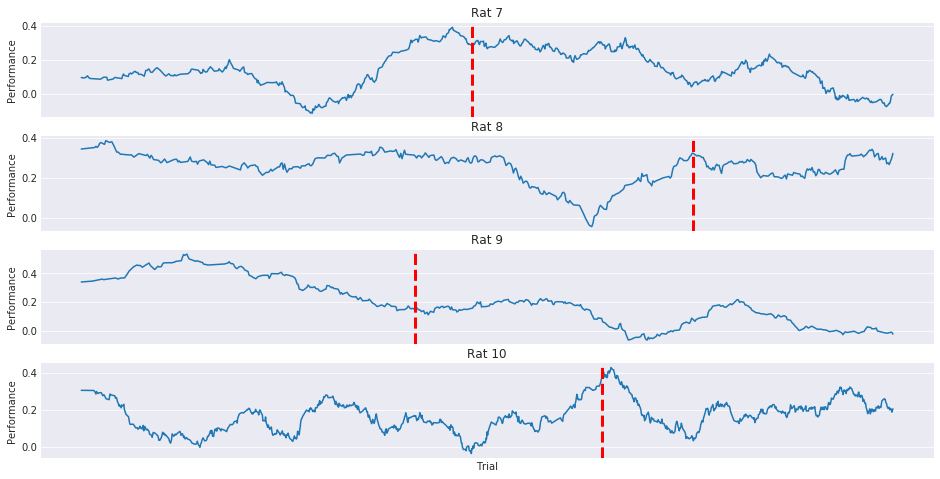

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
fig = plt.figure(figsize=(16,8))
cpoints = {7: [157, 265, 394], 8 :[314, 486, 565], 9 : [176, 713], 10 : [32, 119, 357]}

smoothSize = 50
bestPoin = {7: 500, 8:500, 9:300, 10:1000}
for ratN in [7,8,9,10]:
    for t,window in enumerate([40]):
        plt.subplot(4,1,(ratN-6))
        smoothed = [performanceFromConfusion(results['value'][ratN][:,:,i:i+smoothSize],kind='corr') 
                    for i in range(results['value'][ratN].shape[2]-smoothSize*2)]
        plt.plot(results['trials'][ratN][:results['value'][ratN].shape[2]-smoothSize*2],smoothed)
        #for pt in bestPoin[ratN]:
        plt.axvline(bestPoin[ratN],linestyle='--',color='r',linewidth=3)
    plt.xticks([])
    plt.title('Rat %s'%(ratN))
    plt.ylabel('Performance'); 
plt.xlabel('Trial')
#plt.suptitle('Decoder performance along entire session',fontsize=18)

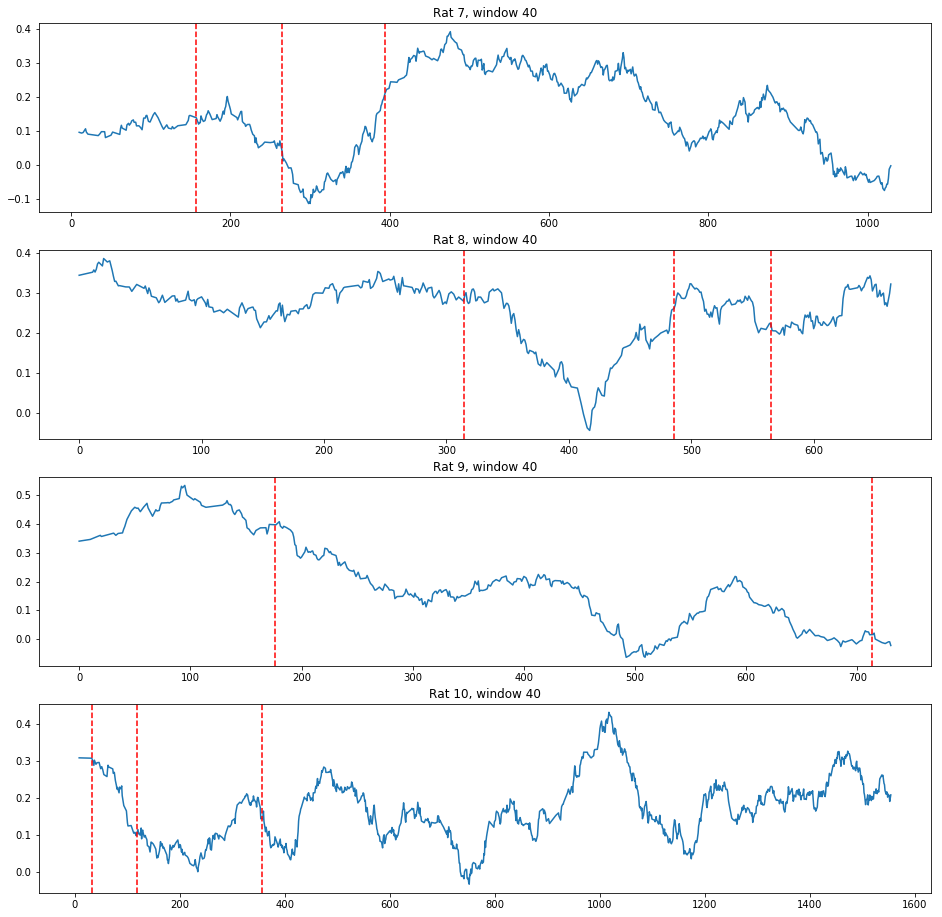

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,16))
cpoints = {7: [157, 265, 394], 8 :[314, 486, 565], 9 : [176, 713], 10 : [32, 119, 357]}

smoothSize = 50
for ratN in [7,8,9,10]:
    for t,window in enumerate([40]):
        plt.subplot(4,1,(ratN-6))
        smoothed = [performanceFromConfusion(results['value'][ratN][:,:,i:i+smoothSize],kind='corr') 
                    for i in range(results['value'][ratN].shape[2]-smoothSize*2)]
        plt.plot(results['trials'][ratN][:results['value'][ratN].shape[2]-smoothSize*2],smoothed)
        for pt in cpoints[ratN]:
            plt.axvline(pt,linestyle='--',color='r')
        plt.title('Rat %s, window %s'%(ratN,window))

/home/tevo/Documents/UFABC/Spikes/spikeHelper/metrics.py:10: RuntimeWarning: invalid value encountered in greater
  cubicConfusion = cubicConfusion[:,cubicConfusion.sum(axis=2).sum(axis=1)>0,:]
/home/tevo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:370: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


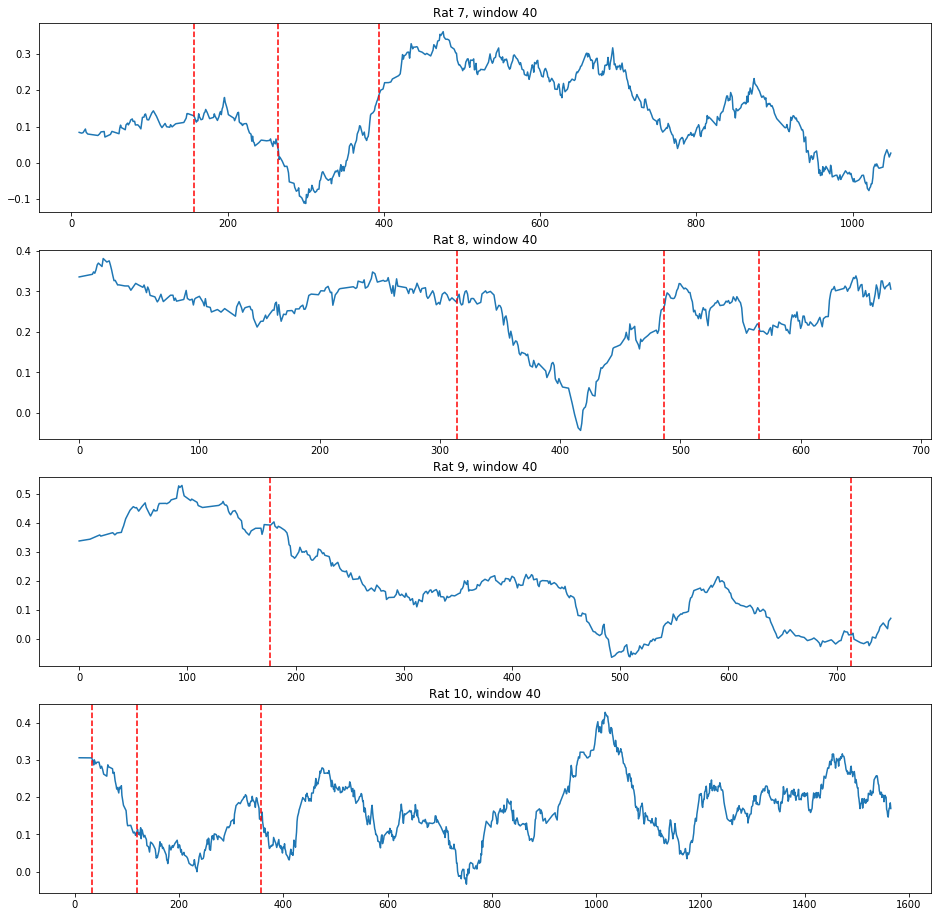

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,16))
cpoints = {7: [157, 265, 394], 8 :[314, 486, 565], 9 : [176, 713], 10 : [32, 119, 357]}

smoothSize = 50
for ratN in [7,8,9,10]:
    for t,window in enumerate([40]):
        plt.subplot(4,1,(ratN-6))
        smoothed = [performanceFromConfusion(results['value'][ratN][:,:,i:i+smoothSize],kind='kappa',weights='quadratic') 
                    for i in range(results['value'][ratN].shape[2]-smoothSize)]
        plt.plot(results['trials'][ratN][:results['value'][ratN].shape[2]-smoothSize],smoothed)
        for pt in cpoints[ratN]:
            plt.axvline(pt,linestyle='--',color='r')
        plt.title('Rat %s, window %s'%(ratN,window))

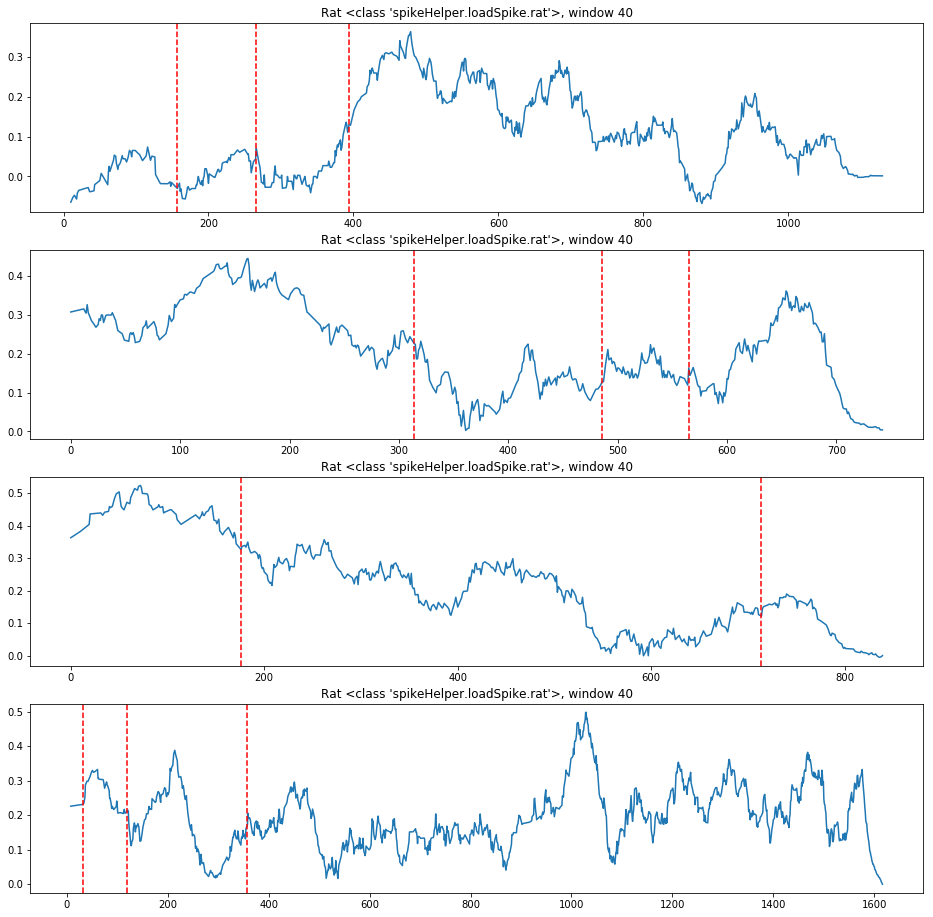

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,16))
cpoints = {7: [157, 265, 394], 8 :[314, 486, 565], 9 : [176, 713], 10 : [32, 119, 357]}

smoothSize = 40
for ratN in [7,8,9,10]:
    for t,window in enumerate([40]):
        plt.subplot(4,1,(ratN-6))
        
        plt.plot(results['trials'][ratN][:results['value'][ratN].shape[2]-smoothSize],
                 [performanceFromConfusion(results['value'][ratN][:,:,i:i+smoothSize]) for i in range(results['value'][ratN].shape[2]-smoothSize)])
        for pt in cpoints[ratN]:
            plt.axvline(pt,linestyle='--',color='r')
        plt.title('Rat %s, window %s'%(ratN,window))

/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


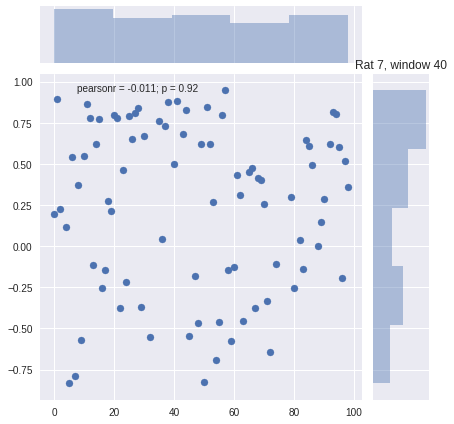

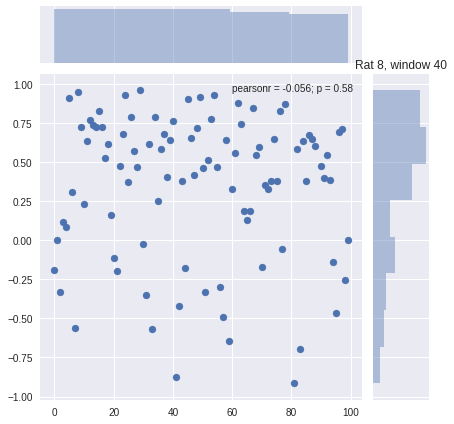

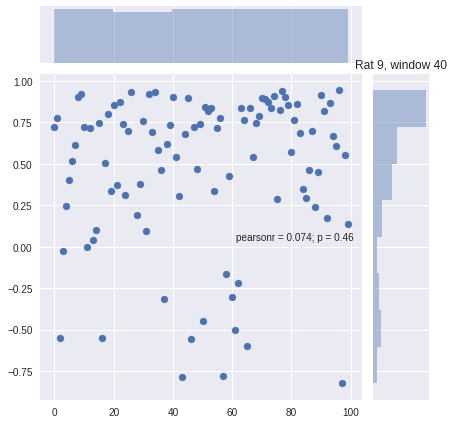

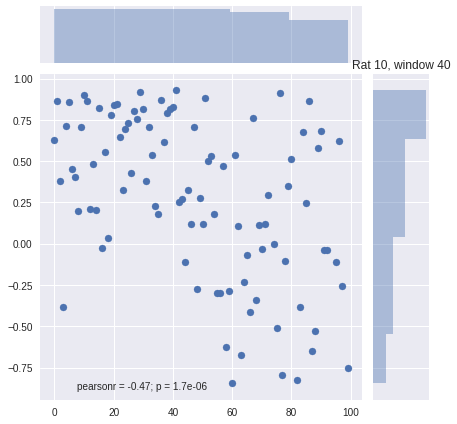

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,16))
for rat in [7,8,9,10]:
    for t,window in enumerate([40]):
        #plt.subplot(4,4,4*(rat-7)+t+1)
        sns.jointplot(x=np.arange(100),y=np.array([performanceFromConfusion(results[window][rat][:,:,i:i+1]) for i in range(100)]))
        plt.title('Rat %s, window %s'%(rat,window))

# Através de bins normalizados

In [13]:
import pandas as pd
from spikeHelper.dataOrganization import loadBestParams, getX,XyTfromEpoch,trialToXyT
from spikeHelper.metrics import performanceFromConfusion
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
import numpy as np


results = pd.DataFrame(columns = ['window','rat','value'])

for windowTrials in [30,40,50,70]:
    ntrials = 100+windowTrials
    for rat in [7,8,9,10]:
        data = pickle.load(open('Data/r'+str(rat)+'_sigma100norm.pickle','rb'))
        data = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86)
        print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))

        parameters = loadBestParams(rat)


        beg = trialToXyT(data[:,:,:ntrials])
        clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
        aux = temporalWindow(getX(beg), beg['y'], beg['trial'],windowTrials, clf,returnCubic=True)
        #aux = performanceFromConfusion(aux)
        results= pd.concat((results,pd.DataFrame({'window':windowTrials,'rat':rat,'value':[aux]},index=[rat])),axis=0) 

results = results.pivot(index='rat',values='value',columns='window')

KeyboardInterrupt: 

In [14]:
data = pickle.load(open('Data/r'+str(rat)+'_sigma100norm.pickle','rb'))